Weak lensing calculation tests
------------------------------

This notebook shows some weak lensing tests: how the reduced shear can be obtained from
measuring background galaxy ellipticities.

In [1]:
%matplotlib inline
import grale.lenses as lenses
import grale.cosmology as cosmology
import grale.plotutil as plotutil
import grale.feedback as feedback
import grale.images as images
from grale.constants import *
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA

V = lambda x,y: np.array([x,y], dtype=np.double)
cosm = cosmology.Cosmology(0.7, 0.27, 0, 0.73)
D = cosm.getAngularDiameterDistance

feedback.setDefaultFeedback("none")

We'll work with a lens model that I've used for strong lensing tests, just to have some
model to work with.

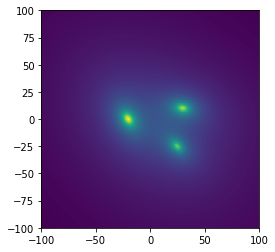

In [2]:
z_lens = 0.4
lens = lenses.GravitationalLens.load("reallens_nosheet.lensdata")
Dd = D(z_lens)

li = plotutil.LensInfo(lens, size=200*ANGLE_ARCSEC, zd=z_lens, cosmology=cosm)
plotutil.plotDensity(li, angularUnit=ANGLE_ARCSEC);

A linear approximation of the lens equation

$$ \vec{\beta}(\vec{\theta}) = \vec{\theta} - \vec{\alpha}(\vec{\theta})$$

around a certain $\vec{\theta}$ and corresponding $\vec{\beta}(\vec{\theta})$ can be written in
matrix form as

$$\left(\begin{array}{c} \Delta\beta_x \\ \Delta\beta_y \end{array} \right) 
\left(\begin{array}{cc} 1-\kappa-\gamma_1 & -\gamma_2 \\ -\gamma_2 & 1-\kappa+\gamma_1 \end{array} \right) 
\left(\begin{array}{c} \Delta\theta_x \\ \Delta\theta_y \end{array} \right) 
$$
This matrix has eigenvalues $1-\kappa-\gamma$ and $1-\kappa+\gamma$, where $\gamma = \sqrt{\gamma_1^2 + \gamma_2^2}$, and corresponding eigenvectors $(\gamma_2, \gamma-\gamma_1)$ and $(\gamma_1-\gamma, \gamma_2)$ respectively. Calling $\phi$ the angle between the line through the the first eigenvector and the $x$ axis, one finds
$$ \gamma_1 = \gamma\cos(2\phi)$$
$$ \gamma_2 = \gamma\sin(2\phi)$$

In a first test, we'll work with a circular source, which will be transformed into an ellipse because of the
transformation above (which is from image plane to source plane, so actually using the inverse transformation). From image plane to source plane, along the axes of the eigenvectors (which are orthogonal), the shape is scaled by $1-\kappa+\gamma$ and $1-\kappa-\gamma$. 

If we go from source plane to lens plane, the eigenvectors will be the same, but the scaling will be the inverse. So a circular source of radius $R$ will be transformed into an ellipse with axes $a = \frac{R}{1-\kappa-\gamma}$ and $b = \frac{R}{1-\kappa+\gamma}$. The ratio of the two is

$$\frac{b}{a} = \frac{1-\kappa-\gamma}{1-\kappa+\gamma} = \frac{1-g}{1+g}$$

where the reduced shear

$$g = \frac{\gamma}{1-\kappa}$$

was introduced. This can be rearranged to get the reduced shear from the axes of the ellipse:

$$g = \frac{1-\frac{b}{a}}{1+\frac{b}{a}}$$

The angle $\phi$ can be derived from the angle that the ellipse makes with the $x$-axis. For a list of vectors, assumed to describe an elliptical shape, the function `estimageAngleAndAxes`below returns this angle, together with the lengths of the long and short axes.

When estimating $a$ and $b$ from the elliptic shape, the resulting quantities will of course be positive. Note that when stating that e.g.  $a = \frac{R}{1-\kappa-\gamma}$, it's possible that this value will actually be negative, and so will differ from the value estimated from the shape. Even worse, based on the eigenvalues themselves, it's not necessarily the case that $1-\kappa-\gamma$ has the smallest absolute value, which would mean that the roles of $a$ and $b$ are actually reversed. These considerations lead to the possibility that for measured (positive) values of $a$ and $b$, where $a > b$, that the correct estimate of $g$ would be the inverse of the formula above:

$$g = \frac{1+\frac{b}{a}}{1-\frac{b}{a}}$$

Of course, solely based on the observed shape of the ellipse, there's no way to know which is actually correct. If we're assuming to be in the weak-lensing regime, where the mass density $\kappa$ is small and shear is small, then the first formula will be the one to use.

In [3]:
def estimateAngleAndAxes(thetas):
    center = np.mean(thetas, axis=0)
    dist = np.sum((thetas-center)**2,1)**0.5
    
    longIdx = np.argmax(dist)
    shortIdx = np.argmin(dist)

    dthetas = thetas-center
    angle = np.arctan2(dthetas[longIdx][1], dthetas[longIdx][0])
    
    plt.plot([center[0], thetas[longIdx][0]], [center[1], thetas[longIdx][1]], label="Long axis estimation", linewidth=3)
    plt.plot([center[0], thetas[shortIdx][0]], [center[1], thetas[shortIdx][1]], label="Short axis estimation", linewidth=3)
    plt.plot([center[0]], [center[1]], 'o', label="Center estimation")
                                              
    return angle, dist[longIdx], dist[shortIdx]

The helper function `getWeakLensingProperties` returns various properties like $\gamma$ or the eigenvectors at a specific point in the image plane, for the specified gravitational lens model:

In [4]:
def getWeakLensingProperties(lens, theta, zs, targetLength=0.05):
    axx, ayy, axy = lens.getAlphaVectorDerivatives(theta)
    frac = D(z_lens,zs)/D(zs)
    axx *= frac
    ayy *= frac
    axy *= frac
    kappa = 0.5*(axx+ayy)
    gamma1 = 0.5*(axx-ayy)
    gamma2 = axy
    gamma = (gamma1**2 + gamma2**2)**0.5
        
    lambda1 = 1-kappa-gamma
    lambda2 = 1-kappa+gamma
    
    def changeLength(xy, targetLength):
        currentLength = (xy[0]**2 + xy[1]**2)**0.5
        return xy * targetLength/currentLength
    
    v1 = changeLength(V(gamma2, gamma-gamma1), targetLength)
    v2 = changeLength(V(gamma1-gamma, gamma2), targetLength)

    return kappa, gamma, gamma1, gamma2, lambda1, lambda2, v1, v2

The helper function `pickBetaTheta` will choose a point $\vec{\beta}$ in the source plane, a redshift of the source, and will calculate the corresponding point $\vec{\theta}$ in the image plane. The helper function `generateBetaCircleAndTrace` will create a list of points that describe a circle centered on the location $\vec{\beta}$ in the source plane, and for each of these points a corresponding point in the image plane will be calculated. This way, we get a circular shape in the source plane, and get to see the corresponding shape in the image plane (which will be an ellipse if the linear approximation holds).

In [5]:
def pickBetaTheta(beta=None, theta=None, zs=None):
    betaOrig = beta
    zsOrig = zs
    while True:
        beta = np.random.uniform(-30*ANGLE_ARCSEC, 30*ANGLE_ARCSEC, 2) if betaOrig is None else betaOrig
        zs = np.random.uniform(1.5,4) if zsOrig is None else zsOrig

        if theta is None:
            li.setSourceRedshift(zs)
            ip = li.getImagePlane()
            trace = ip.traceBeta(beta)
            if len(trace) > 0:
                theta = trace[0]
                break
            else:
                if betaOrig is not None:
                    raise Exception("Using beta that can't be traced")
                #print("Retrying...")
        else:
            break
            
    return beta, theta, zs

def generateBetaCircleAndTrace(beta, betaRadius, numPts):
    angles = np.linspace(0, np.pi*2, numPts)
    betas = np.zeros((numPts,2))
    betas[:,0] = betaRadius*np.cos(angles) + beta[0]
    betas[:,1] = betaRadius*np.sin(angles) + beta[1]
    ip = li.getImagePlane()
    thetas = np.array([ ip.traceBeta(i)[0] for i in betas ])
    return betas, thetas

The function `estimateReducedShearFromDeformedCircularSource` will do a small first test: it creates a circular source at a random location and calculates the corresponding shape in the image plane. From this shape, the angle it makes with the $x$-axis and the long and short ellipse axes are estimated and using the formulas above the reduced shear and it's components are estimated. The true values, directly from the lens model are shown as well for comparison.

In [6]:
def estimateReducedShearFromDeformedCircularSource():
    
    def plotVector(v, *args, **kwargs):
        plt.plot([0, v[0]], [0, v[1]], *args, **kwargs)
    
    beta, theta, zs = pickBetaTheta()
    betaArcsec = beta/ANGLE_ARCSEC
    thetaArcsec = theta/ANGLE_ARCSEC
    betas, thetas = generateBetaCircleAndTrace(beta, 0.1*ANGLE_ARCSEC, 500)
    
    betasArcsec = (betas-beta)/ANGLE_ARCSEC 
    thetasArcsec = (thetas-theta)/ANGLE_ARCSEC
    
    plt.subplot(1,2,1)
    plt.plot(betasArcsec[:,0], betasArcsec[:,1])
    plt.gca().set_title("Source (recentered)")
    plt.gca().set_aspect("equal")

    kappa, gamma, gamma1, gamma2, lambda1, lambda2, v1, v2 = getWeakLensingProperties(lens, theta, zs, 0.2)
    plotVector(v1, 'red', label="Eigenvector 1")
    plotVector(v2, 'blue', label="Eigenvector 2")
    plt.gca().legend()

    plt.subplot(1,2,2)
    angle, longAxis, shortAxis = estimateAngleAndAxes(thetasArcsec)
    plt.plot(thetasArcsec[:,0], thetasArcsec[:,1], '-')
    plt.gca().set_title("Image (recentered)")
    plt.gca().set_aspect("equal")
    
    #plotVector(thetaArcsec, v1, 'red')
    #plotVector(thetaArcsec, v2, 'blue') 
    plotVector(v1, 'red', label="Eigenvector 1")
    plotVector(v2, 'blue', label="Eigenvector 2")
    plt.gca().legend()

    print("True values:")
    print(" lambda1 =", lambda1)
    print(" lambda2 =", lambda2)
    print(" 1/lambda1 =", 1/lambda1)
    print(" 1/lambda2 =", 1/lambda2)
    print(" gamma", gamma)
    print(" kappa", kappa)
    print(" g ", abs(gamma/(1-kappa)))
    print(" g1", gamma1/(1-kappa))
    print(" g2", gamma2/(1-kappa))
    print()
    
    e = (shortAxis/longAxis)
    gEst = (1-e)/(1+e)
    g1Est = gEst*np.cos(angle*2)
    g2Est = gEst*np.sin(angle*2)
    print("Estimate based on g = (1-b/a)/(1+b/a)")
    print(" g ", gEst)
    print(" g1", g1Est)
    print(" g2", g2Est)
    print()
    
    gEst = (1+e)/(1-e)
    g1Est = gEst*np.cos(angle*2)
    g2Est = gEst*np.sin(angle*2)
    print("Estimate based on g = (1+b/a)/(1-b/a)")
    print(" g ", gEst)
    print(" g1", g1Est)
    print(" g2", g2Est)
    print()


To illustrate this, we'll call the routine a number of times.

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = 0.4222819587977569
 lambda2 = 1.0765846429687478
 1/lambda1 = 2.368086012594559
 1/lambda2 = 0.9288633332558405
 gamma 0.32715134208549546
 kappa 0.25056669911674767
 g  0.4365316322345536
 g1 -0.0956588737576958
 g2 -0.42592164280859546

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.4380662269970656
 g1 -0.09727585132412561
 g2 -0.42712928720073884

Estimate based on g = (1+b/a)/(1-b/a)
 g  2.2827598622586778
 g1 -0.5069037403133204
 g2 -2.2257675500365317



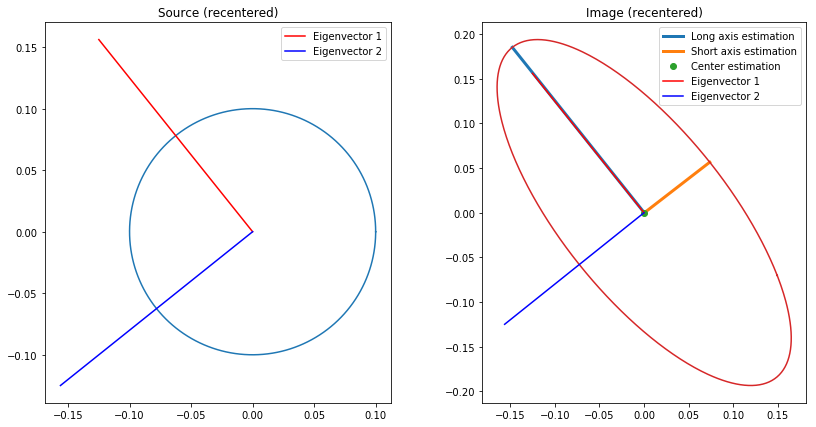

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = -0.7254332294452276
 lambda2 = 0.4188942691395777
 1/lambda1 = -1.378486619319529
 1/lambda2 = 2.387237242595923
 gamma 0.5721637492924027
 kappa 1.153269480152825
 g  3.7330572839543685
 g1 2.3965197408144885
 g2 -2.8622386024179085

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.274924353673529
 g1 0.17717274539094394
 g2 -0.2102218317241181

Estimate based on g = (1+b/a)/(1-b/a)
 g  3.637364193597392
 g1 2.3440695287825886
 g2 -2.7813227646386856



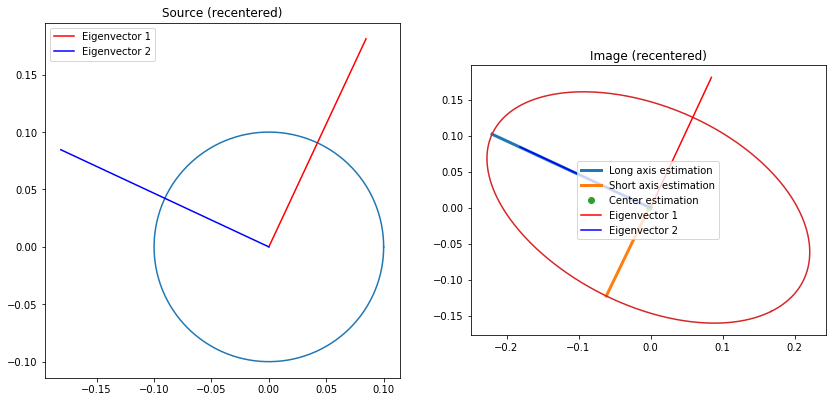

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = -0.5808357640049564
 lambda2 = 0.807106950591099
 1/lambda1 = -1.721657070674916
 1/lambda2 = 1.2389931709392816
 gamma 0.6939713572980277
 kappa 0.8868644067069287
 g  6.133979034346285
 g1 5.075220277828637
 g2 3.4449728482698956

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.1637190671702489
 g1 0.1346439657343723
 g2 0.093139333508554

Estimate based on g = (1+b/a)/(1-b/a)
 g  6.108024051713632
 g1 5.0232913938389485
 g2 3.474838325576567



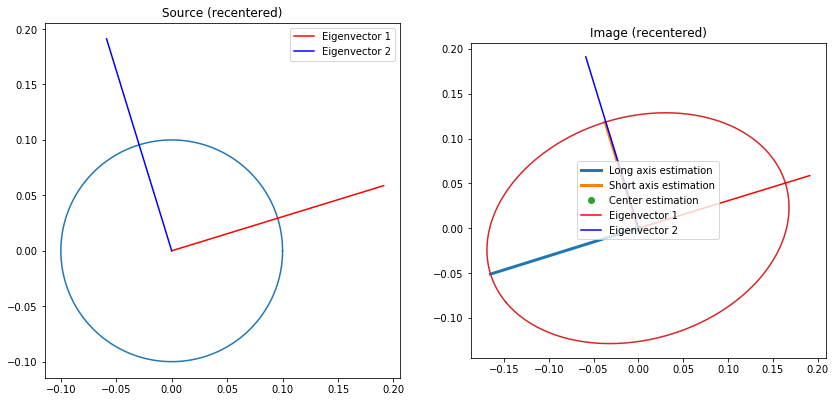

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = -5.298992512771434
 lambda2 = -3.533278810415286
 1/lambda1 = -0.18871511850410003
 1/lambda2 = -0.28302323526018724
 gamma 0.8828568511780743
 kappa 5.41613566159336
 g  0.19991615267986035
 g1 -0.014244700697067594
 g2 -0.19940801539649353

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.20114557094995758
 g1 -0.014961952784793672
 g2 -0.20058833635495865

Estimate based on g = (1+b/a)/(1-b/a)
 g  4.971523833596053
 g1 -0.3698003615761755
 g2 -4.957751195914507



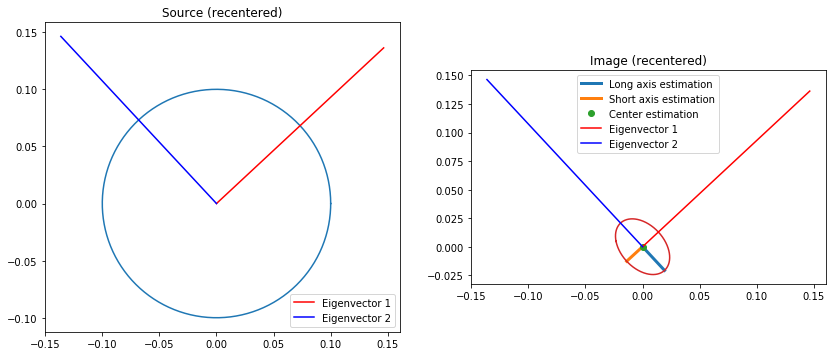

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = 0.2481324898069726
 lambda2 = 1.0099849389272404
 1/lambda1 = 4.030105049032155
 1/lambda2 = 0.9901137744312841
 gamma 0.38092622456013386
 kappa 0.3709412856328936
 g  0.6055495550099521
 g1 0.2355995545049613
 g2 -0.5578378917658917

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.6076025084609635
 g1 0.23569842649272463
 g2 -0.5600241602260647

Estimate based on g = (1+b/a)/(1-b/a)
 g  1.6458128234739615
 g1 0.6384362924651806
 g2 -1.516937358751062



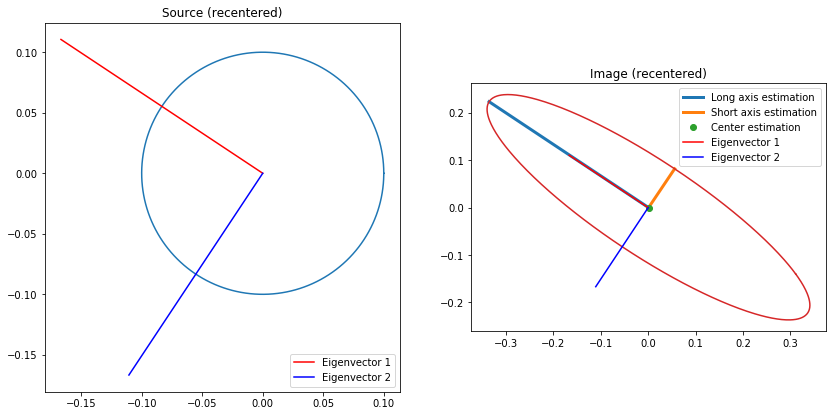

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = 0.3601841798257571
 lambda2 = 1.1139728520097227
 1/lambda1 = 2.7763573638457983
 1/lambda2 = 0.897687944724951
 gamma 0.37689433609198286
 kappa 0.26292148408226
 g  0.5113353977258582
 g1 -0.4847170220227555
 g2 -0.16282904387379166

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.5128770428664161
 g1 -0.4869421663438802
 g2 -0.16102853081279886

Estimate based on g = (1+b/a)/(1-b/a)
 g  1.9497850681931572
 g1 -1.851189438514633
 g2 -0.6121760162574752



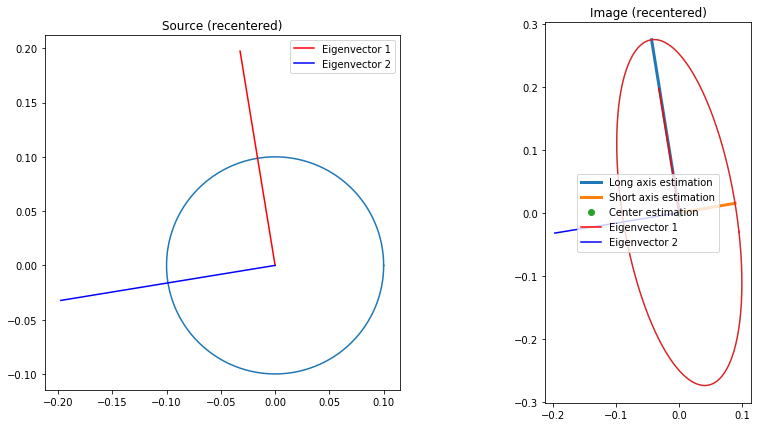

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = 0.13384913059032078
 lambda2 = 1.080423159527426
 1/lambda1 = 7.4710982102734285
 1/lambda2 = 0.9255632769269747
 gamma 0.4732870144685527
 kappa 0.3928638549411265
 g  0.7795401712126009
 g1 0.313634076260012
 g2 0.7136641680389313

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.7824436686645205
 g1 0.30939990751409
 g2 0.7186722423076228

Estimate based on g = (1+b/a)/(1-b/a)
 g  1.278047276817775
 g1 0.5053753069802106
 g2 1.1738827202391169



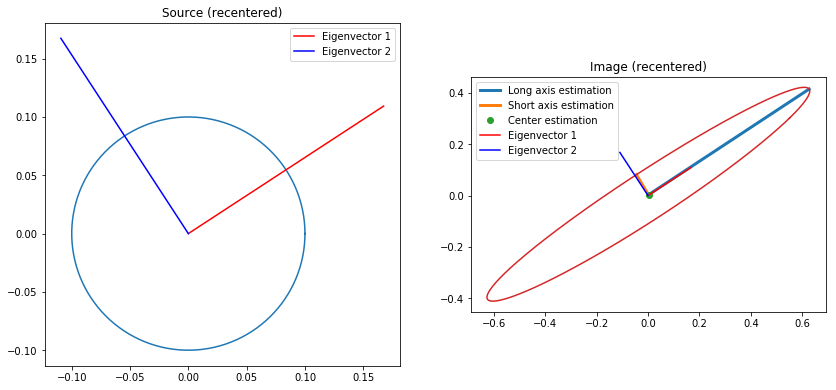

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = 0.29734947234113324
 lambda2 = 1.0773475984924248
 1/lambda1 = 3.363046156183365
 1/lambda2 = 0.9282055312503965
 gamma 0.38999906307564575
 kappa 0.3126514645832211
 g  0.5673963687711459
 g1 0.5657677720808149
 g2 0.04295890326106223

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.5684571100717835
 g1 0.5670230909480921
 g2 0.04035220344461293

Estimate based on g = (1+b/a)/(1-b/a)
 g  1.7591476688078056
 g1 1.7547099524809766
 g2 0.1248739497899591



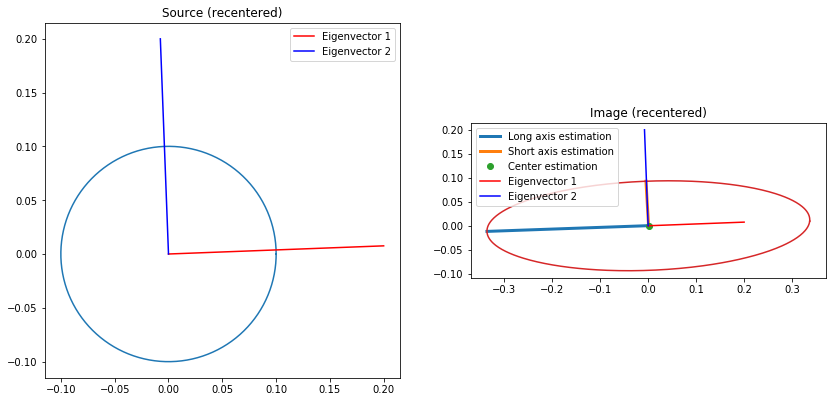

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = 0.36180009183603284
 lambda2 = 1.1223279153685424
 1/lambda1 = 2.7639572862607182
 1/lambda2 = 0.8910051922495635
 gamma 0.3802639117662548
 kappa 0.25793599639771236
 g  0.5124408540507226
 g1 -0.4838997956326272
 g2 -0.16863160049924109

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.5139369206200312
 g1 -0.4853412770903161
 g2 -0.16904142429813226

Estimate based on g = (1+b/a)/(1-b/a)
 g  1.9457640809178796
 g1 -1.8375010357493697
 g2 -0.6399904704057662



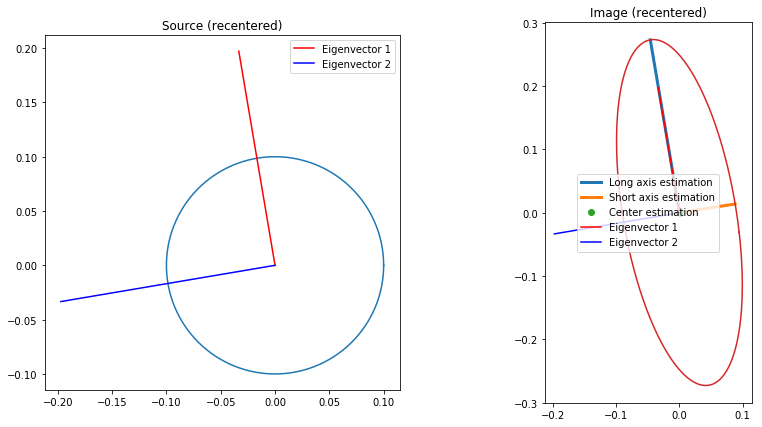

-----------------------------------------------------------------------------------------------
True values:
 lambda1 = 0.32377736068466073
 lambda2 = 1.048305963100445
 1/lambda1 = 3.0885420706543427
 1/lambda2 = 0.9539199767999255
 gamma 0.36226430120789216
 kappa 0.3139583381074471
 g  0.5280500023985856
 g1 0.16632082041352847
 g2 -0.5011728142368828

Estimate based on g = (1-b/a)/(1+b/a)
 g  0.5297398252186118
 g1 0.16721702294223853
 g2 -0.502655696934771

Estimate based on g = (1+b/a)/(1-b/a)
 g  1.8877191262471575
 g1 0.59587510210679
 g2 -1.7912052820066588



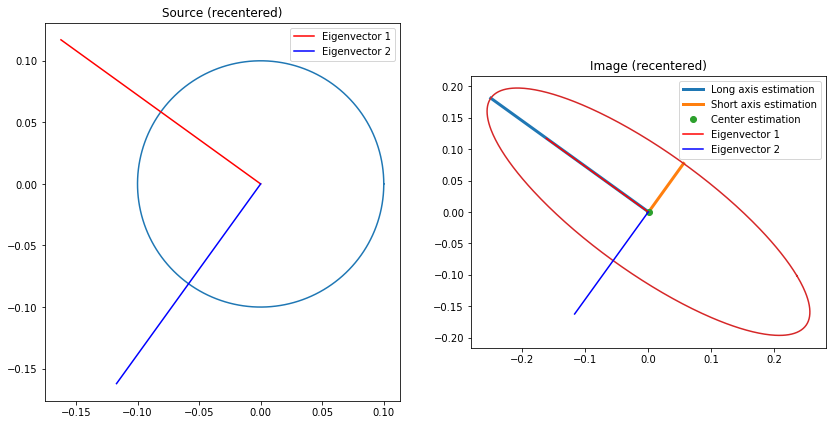

In [7]:
for i in range(10):
    print("-----------------------------------------------------------------------------------------------")
    plt.figure(figsize=(14,7))
    estimateReducedShearFromDeformedCircularSource()
    plt.show()

In [8]:
def estGFromEll(noiseLevel=0, simulateMeasurement = False):
    theta = np.random.uniform(-100*ANGLE_ARCSEC, 100*ANGLE_ARCSEC, 2)
    zs = 2
    kappa, gamma, gamma1, gamma2, lambda1, lambda2, v1, v2 = getWeakLensingProperties(lens, theta, zs, 1)

    if not simulateMeasurement:
        g = gamma/(1-kappa)
        a = 1/(1-kappa-gamma)
        b = 1/(1-kappa+gamma)
    else:
        g = abs(gamma/(1-kappa))
        a = abs(1/(1-kappa-gamma))
        b = abs(1/(1-kappa+gamma))

    a *= np.random.normal(1, noiseLevel)
    b *= np.random.normal(1, noiseLevel)

    if simulateMeasurement:
        if a < b:
            a, b = b, a

    aOverB = a/b
    gEst = (aOverB-1)/(aOverB+1)
    return kappa, g, gEst, abs(g-gEst)

def plotNPHist(h, *args, **kwargs):
    counts, edges = h
    if False:
        binWidth = edges[1]-edges[0]
        center = (edges[:-1] + edges[1:])/2
        plt.bar(center, counts, *args, align='center', width=binWidth, **kwargs)
    else:
        y = np.array([counts,counts]).T.reshape((-1,))
        x = np.array([edges, edges]).T.reshape((-1,))[1:-1]
        plt.plot(x, y, *args, **kwargs)

def plotNoiseSensitivity(noiseLevel, numPts, gDiffThreshold, simulateMeasurement=False, *args, **kwargs):
    a = np.array([ estGFromEll(noiseLevel, simulateMeasurement=simulateMeasurement) for i in range(numPts) ])
    correctBelowThreshold = a[a[:,3] < gDiffThreshold][:,0]
    total = a[:,0]
    
    kappaRange = [0.1, 3]
    numBins = 100
    corrCount = np.histogram(correctBelowThreshold, bins=numBins, range=kappaRange)
    totalCount = np.histogram(total, bins=numBins, range=kappaRange)
    frac = corrCount[0]/totalCount[0], corrCount[1]
    plotNPHist(frac, *args, **kwargs)
    plt.gca().set_xlim(kappaRange)


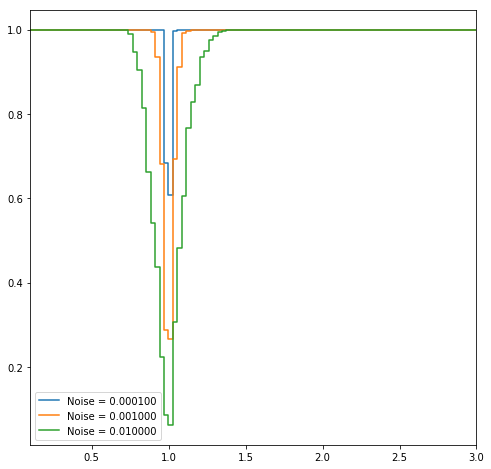

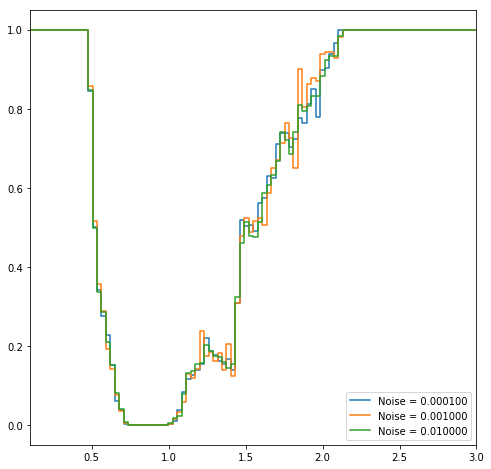

In [9]:
numPoints = 100000
gErrorTolerance = 0.1
baseNoise = 0.0001
for simulateMeasurement in [ False, True]:
    plt.figure(figsize=(8,8))
    for i in range(3):
        noise = baseNoise*10**i
        plotNoiseSensitivity(noise, numPoints, gErrorTolerance, simulateMeasurement, label =f"Noise = {noise:05f}")
    plt.legend()

In [10]:
# Derivations for these formulas can be found at
# https://nbviewer.jupyter.org/url/research.edm.uhasselt.be/~jori/grale2/_static/ellipsetransform.ipynb

def getTransFormedEllipseParamsABC(a, b, theta, A, B, C):
    
    sin = np.sin
    cos = np.cos
    sqrt = np.sqrt
    
    C_x = (A*sin(theta) - B*cos(theta))**2/b**2 + (A*cos(theta) + B*sin(theta))**2/a**2
    C_y = (B*sin(theta) - C*cos(theta))**2/b**2 + (B*cos(theta) + C*sin(theta))**2/a**2
    C_xy = 2*(a**2*(A*sin(theta) - B*cos(theta))*(B*sin(theta) - C*cos(theta)) + b**2*(A*cos(theta) + B*sin(theta))*(B*cos(theta) + C*sin(theta)))/(a**2*b**2)
    
    a_new = sqrt(2/((C_x+C_y)-sqrt(C_xy**2+(C_x-C_y)**2)))
    b_new = sqrt(2/((C_x+C_y)+sqrt(C_xy**2+(C_x-C_y)**2)))
    
    cosTwoTheta_new = -(C_x-C_y)*(a_new**2*b_new**2)/(a_new**2-b_new**2)
    sinTwoTheta_new = C_xy*(C_x+C_y)/(1/a_new**4-1/b_new**4)
    theta_new = 0.5*np.arctan2(sinTwoTheta_new, cosTwoTheta_new)
    
    return a_new, b_new, theta_new
    
def getTransFormedEllipseParams(a, b, theta, kappa, gamma1, gamma2, inverse = False):
    if inverse:
        denom = (1-kappa-gamma1)*(1-kappa+gamma1) - gamma2**2
        det = 1/denom
        A = det*(1-kappa+gamma1)
        B = det*gamma2
        C = det*(1-kappa-gamma1)
    else:
        A = 1-kappa-gamma1
        B = -gamma2
        C = 1-kappa+gamma1
    return getTransFormedEllipseParamsABC(a, b, theta, A, B, C)

In [11]:
def plotEllipse(a, b, rotAngle):
    angles = np.linspace(0, np.pi*2, 20)
    x = a*np.cos(angles)
    y = b*np.sin(angles)
    xy = np.array([x,y])
    rotMatrix = np.array([[ np.cos(rotAngle), -np.sin(rotAngle)],[ np.sin(rotAngle), np.cos(rotAngle)]])
    xyRot = rotMatrix.dot(xy).T
    plt.plot(xyRot[:,0], xyRot[:,1], 'o')

In [12]:
def generateBetaEllipseAndTrace(beta, betaRadius, betaE, betaAngle, numPts):
    angles = np.linspace(0, np.pi*2, numPts)
    betas = np.zeros((numPts,2))

    x = betaRadius*np.cos(angles)
    y = betaRadius*betaE*np.sin(angles)
    xy = np.array([x,y])
    
    rotAngle = betaAngle
    rotMatrix = np.array([[ np.cos(rotAngle), -np.sin(rotAngle)],[ np.sin(rotAngle), np.cos(rotAngle)]])
    xyRot = rotMatrix.dot(xy)
    betas[:,0] = xyRot[0,:] + beta[0]
    betas[:,1] = xyRot[1,:] + beta[1]
    ip = li.getImagePlane()
    thetas = np.array([ ip.traceBeta(i)[0] for i in betas ])
    return betas, thetas

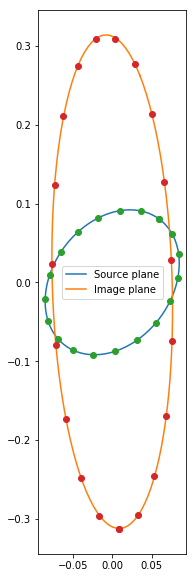

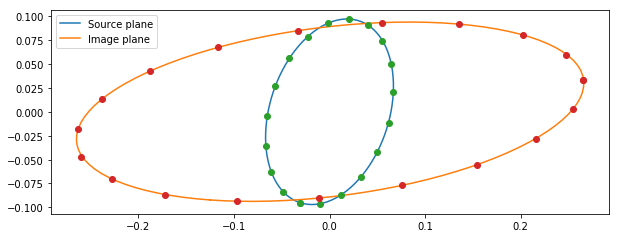

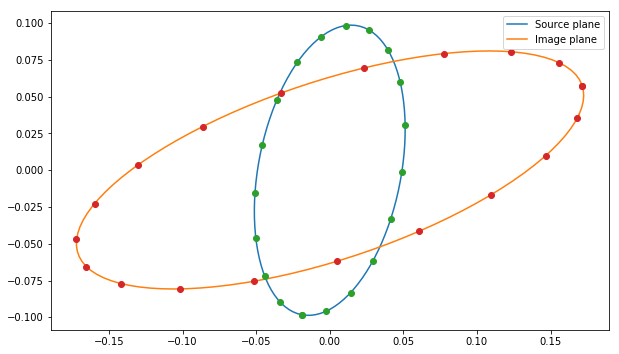

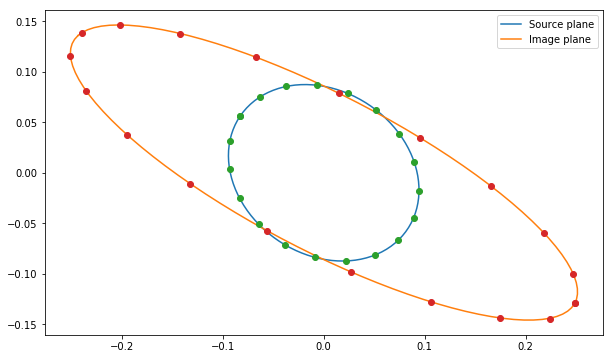

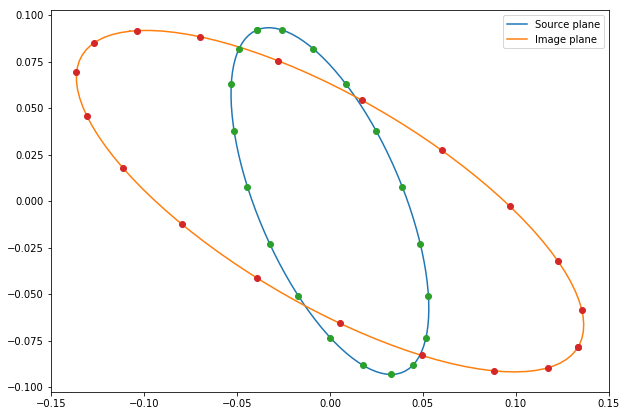

In [13]:
def getTransFormedRandomEllipseParams(plot=False, beta=None, theta=None, zs=None, betaE=None, betaAngle = None):
    beta, theta, zs = pickBetaTheta(beta, theta, zs)
    #print(beta, theta, zs)
    kappa, gamma, gamma1, gamma2, lambda1, lambda2, v1, v2 = getWeakLensingProperties(lens, theta, zs)
    
    betaRadius = 0.1
    betaE = np.random.uniform(0.1,0.9) if betaE is None else betaE
    betaAngle = np.random.uniform(0,2*np.pi) if betaAngle is None else betaAngle
    
    if plot:
        betas, thetas = generateBetaEllipseAndTrace(beta, betaRadius*ANGLE_ARCSEC, betaE, betaAngle, 100)
        betas = (betas-beta)/ANGLE_ARCSEC
        thetas = (thetas-theta)/ANGLE_ARCSEC

        plt.plot(betas[:,0],betas[:,1], label='Source plane')
        plt.plot(thetas[:,0],thetas[:,1], label='Image plane')
        plt.gca().set_aspect("equal")
        plt.gca().legend()

    a_new, b_new, theta_new = getTransFormedEllipseParams(betaRadius, betaRadius*betaE, betaAngle, kappa, gamma1, gamma2)
    if plot:    
        plotEllipse(betaRadius, betaRadius*betaE, betaAngle)
        plotEllipse(a_new, b_new, theta_new)

    return betaRadius, betaRadius*betaE, betaAngle, a_new, b_new, theta_new

for i in range(5):
    plt.figure(figsize=(10,10))
    getTransFormedRandomEllipseParams(True)

In [14]:
def getRealAndEstimatedShearFromEllipses(kappaThresholdFunction, num, betaE=None, noiseLevel=0):
    while True:
        beta, theta, zs = pickBetaTheta()
        kappa, gamma, gamma1, gamma2, lambda1, lambda2, v1, v2 = getWeakLensingProperties(lens, theta, zs)
        if kappaThresholdFunction(kappa): 
            break

    g1Ests = [ ]
    g2Ests = [ ]
    for i in range(num):
        a_orig, b_orig, theta_orig, a_new, b_new, theta_new = getTransFormedRandomEllipseParams(False, beta, theta, zs,
                                                                                                betaE=betaE)

        a_new *= np.random.normal(1, noiseLevel)
        b_new *= np.random.normal(1, noiseLevel)

        aOverB = a_new/b_new
        gEst = (aOverB-1)/(aOverB+1)
        g1Est = gEst*np.cos(2*theta_new)
        g2Est = gEst*np.sin(2*theta_new)

        g1Ests.append(g1Est)
        g2Ests.append(g2Est)

    return kappa, gamma1, gamma2, g1Ests, g2Ests

kappa, gamma1, gamma2, g1Ests, g2Ests = getRealAndEstimatedShearFromEllipses(lambda kappa: abs(1-kappa) > 0.5, 
                                                                             150, betaE=None, noiseLevel=0.01)
print("kappa =", kappa)
print("g1,real = ", gamma1/(1-kappa))
print("g2,real = ", gamma2/(1-kappa))
print("g1Est,mean =", np.mean(g1Ests))
print("g2Est,mean =", np.mean(g2Ests))

kappa = 0.27230641274841894
g1,real =  -0.33471359658699623
g2,real =  -0.4025459764649922
g1Est,mean = -0.3465093472281576
g2Est,mean = -0.39033376364764183


In [15]:
def getEstimatedShearDeviations(kappaThresholdFunction, numEllipses, numRepeats, noiseLevel=0):
    g1Diffs, g2Diffs = [], []
    for i in range(numRepeats):
        kappa, gamma1, gamma2, g1Ests, g2Ests = getRealAndEstimatedShearFromEllipses(kappaThresholdFunction, 
                                                                             numEllipses, 
                                                                             betaE=None, noiseLevel=noiseLevel)
        g1Est, g2Est = np.mean(g1Ests), np.mean(g2Ests)
        g1Diffs.append(gamma1/(1-kappa) - g1Est)
        g2Diffs.append(gamma2/(1-kappa) - g2Est)
    
    return g1Diffs, g2Diffs

In [16]:
numEllipses = [ 1, 5, 10, 25, 50, 100, 200 ]
numRepeats = 100
precisions = [ ]
for n in numEllipses:
    g1Diffs, g2Diffs = getEstimatedShearDeviations(lambda kappa: abs(1-kappa) > 0.5, n, numRepeats)
    p = np.std(g1Diffs+g2Diffs)
    precisions.append(p)
    print(n, p)    

1 0.22402927605319256
5 0.08485721108428464
10 0.07389557437994392
25 0.09539828337459379
50 0.03135299931554571
100 0.022745553051010264
200 0.016348153985165682


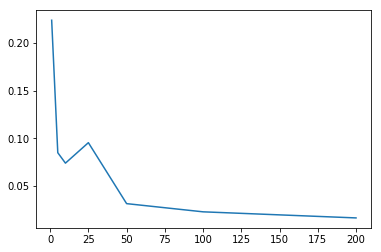

In [17]:
plt.plot(numEllipses, precisions)

In [18]:
def plotVectors(vectors, angularScale=1, lengthFactor=1, **kwargs):
    
    xCoords, yCoords = [], []
    for cx, cy, vx, vy in vectors:
        length = (vx**2+vy**2)**0.5
        phi = np.arctan2(vy, vx)
        
        xCoords.append((cx/angularScale - length*lengthFactor*np.cos(phi)))
        xCoords.append((cx/angularScale + length*lengthFactor*np.cos(phi)))
        xCoords.append(None)
        yCoords.append((cy/angularScale - length*lengthFactor*np.sin(phi)))
        yCoords.append((cy/angularScale + length*lengthFactor*np.sin(phi)))
        yCoords.append(None)
        
    plt.plot(xCoords, yCoords, '-', **kwargs)
    plt.gca().set_xlim([vectors[:,0].min()/angularScale, vectors[:,0].max()/angularScale])
    plt.gca().set_ylim([vectors[:,1].min()/angularScale, vectors[:,1].max()/angularScale])


def plotShear(thetas, kappa, gamma1, gamma2, lengthFactor, angularScale=1, plotType="real", **kwargs):
    thetas = thetas.reshape((-1,2))
    kappa = kappa.reshape((-1,))
    gamma1 = gamma1.reshape((-1,))
    gamma2 = gamma2.reshape((-1,))
    gamma = (gamma1**2+gamma2**2)**0.5
    
    if plotType == "real":
        lengths = gamma
        angles = 0.5*np.arctan2(gamma2, gamma1)
    elif plotType == "realreduced":
        lengths = gamma/(1-kappa)
        angles = 0.5*np.arctan2(gamma2, gamma1)
    elif plotType == "measuredreduced":
        l1 = 1/(1-kappa-gamma)
        l2 = 1/(1-kappa+gamma)
        v1 = np.array([ gamma2, gamma-gamma1 ]).T
        v2 = np.array([ gamma1-gamma, gamma2 ]).T
        
        b = np.abs(l2.copy())
        a = np.abs(l1.copy())
        v = v1.copy()
        flag = a < b
        a[flag] = np.abs(l2[flag])
        b[flag] = np.abs(l1[flag])
        v[flag] = v2[flag]
        
        e = b/a
        g = (1-e)/(1+e)
        
        lengths = g
        angles = np.arctan2(v[:,1], v[:,0])
    else:
        raise Exception(f"Unknown plotType '{plotType}'")
        
    angles[angles < 0] += 2.0*np.pi
    angles[angles > np.pi] -= np.pi
    
    vectors = [ ]
    for i in range(len(thetas)):
        cx = thetas[i,0]
        cy = thetas[i,1]
        length = lengths[i]
        phi = angles[i]
        
        vectors.append([cx,cy, length*np.cos(phi), length*np.sin(phi)])
        
    vectors = np.array(vectors)
    plotVectors(vectors, angularScale=angularScale, lengthFactor=lengthFactor, **kwargs)
    return np.array(vectors)


In [19]:
def createThetas(bottomLeft, topRight, numX, numY):
    thetas = np.empty([numY,numX,2], dtype=np.double)
    thetas[:,:,0], thetas[:,:,1] = np.meshgrid(np.linspace(bottomLeft[0], topRight[0], numX),
                                               np.linspace(bottomLeft[1], topRight[1], numY))
    return thetas

In [20]:
zs = 1
Ds = cosm.getAngularDiameterDistance(zs)
Dds = cosm.getAngularDiameterDistance(z_lens, zs)
strongSize = 200*ANGLE_ARCSEC
thetas = createThetas([-strongSize/2, -strongSize/2],[strongSize/2, strongSize/2], 48,48)
a = lens.getAlphaVectorDerivatives(thetas)
a *= Dds/Ds
axx, ayy, axy = a[:,:,0], a[:,:,1], a[:,:,2]
kappa = 0.5*(axx+ayy)
gamma1 = 0.5*(axx-ayy)
gamma2 = axy

In [21]:
sources = [ ]
for pos in thetas.reshape((-1,2)):
    sources.append(images.CircularSource(pos, 0.2*ANGLE_ARCSEC))

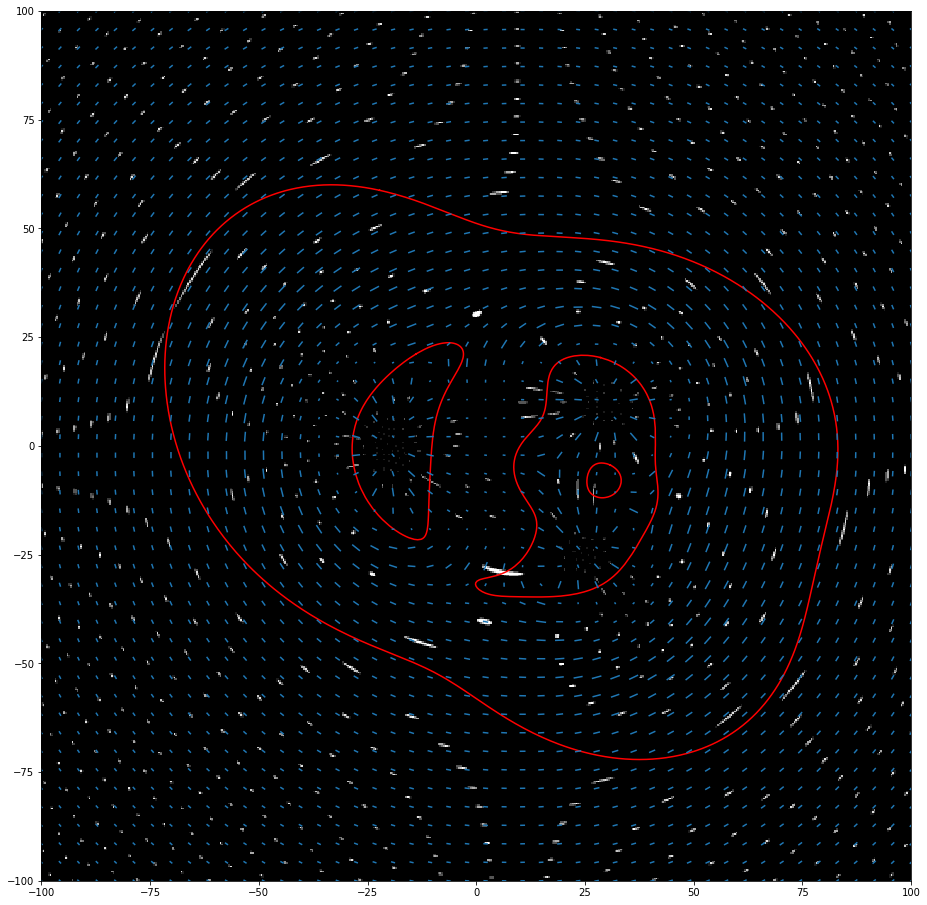

In [22]:
lengthFactor=1
plt.figure(figsize=(16,16))
plotutil.plotImagePlane(li, sources, plotSources=False, plotCaustics=False, angularUnit=ANGLE_ARCSEC)
vMR = plotShear(thetas, kappa, gamma1, gamma2, lengthFactor, angularScale=ANGLE_ARCSEC, plotType="measuredreduced")

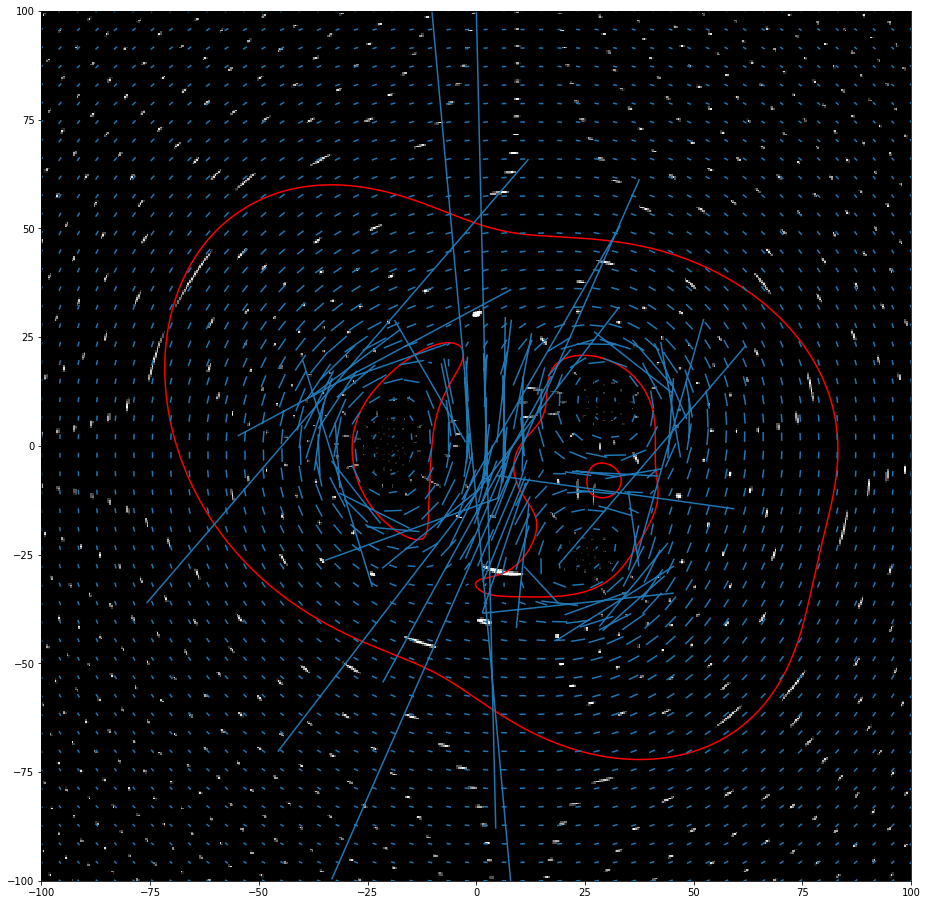

In [23]:
lengthFactor=1
plt.figure(figsize=(16,16))
plotutil.plotImagePlane(li, sources, plotSources=False, plotCaustics=False, angularUnit=ANGLE_ARCSEC)
vRR = plotShear(thetas, kappa, gamma1, gamma2, lengthFactor, angularScale=ANGLE_ARCSEC, plotType="realreduced")

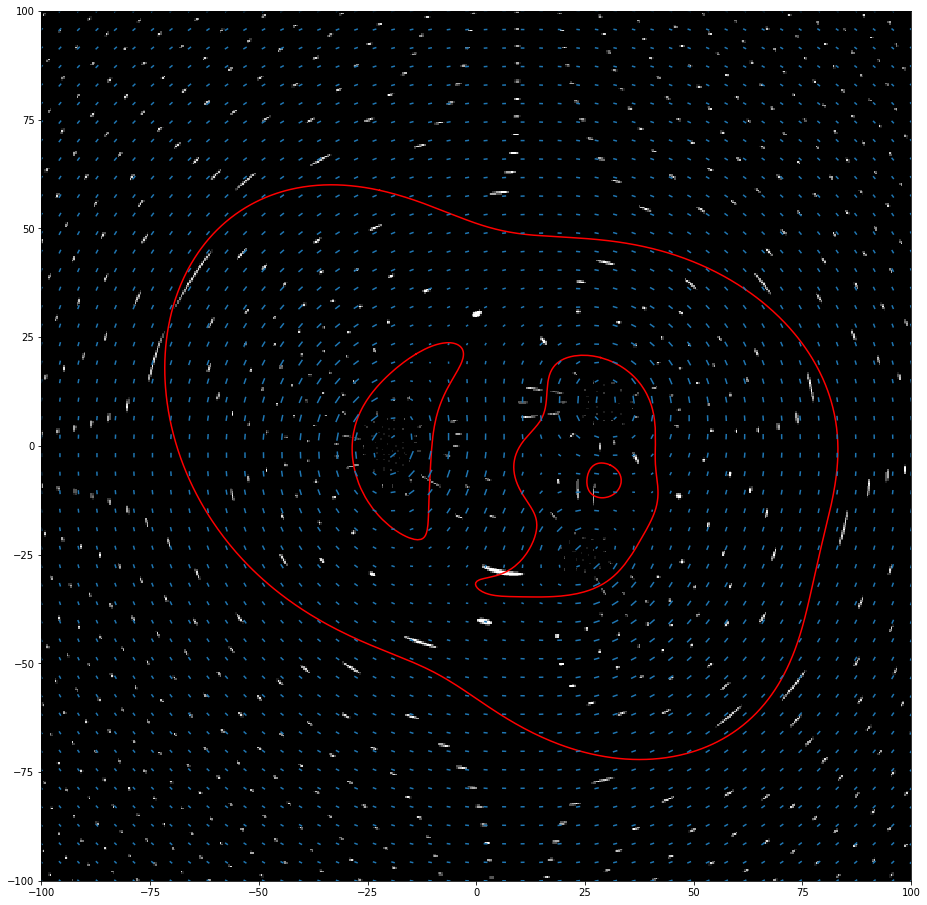

In [24]:
lengthFactor=1
plt.figure(figsize=(16,16))
plotutil.plotImagePlane(li, sources, plotSources=False, plotCaustics=False, angularUnit=ANGLE_ARCSEC)
vR = plotShear(thetas, kappa, gamma1, gamma2, lengthFactor, angularScale=ANGLE_ARCSEC, plotType="real")